<a href="https://colab.research.google.com/github/ArjunJanakiraman/Red-Wine-Quality-Analysis/blob/main/Red_Wine_Quality_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Data Inspection

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

%matplotlib inline

# Load file
df = pd.read_csv('winequality-red.csv', sep=';')

In [107]:
# Initial Data Inspection
print("--- DataFrame Information ---\n")
df.info()

# Check key statistics (used to justify Feature Scaling)
print("\n--- Descriptive Statistics (Scale Variance Check) ---")
print(df.describe().T)

# Check target distribution to assess imbalance (used to justify F1-Score)
print("\n--- Target Distribution Check (Class Imbalance) ---")
print(df['quality'].value_counts().sort_index())

--- DataFrame Information ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

--- Descriptive Statistics (Scale Variance Check) ---
                       count       mean 

## Data Analysis and Coorelation

--- Top 5 Feature Correlations with Quality Score ---
quality          1.000000
alcohol          0.476166
sulphates        0.251397
citric acid      0.226373
fixed acidity    0.124052
Name: quality, dtype: float64


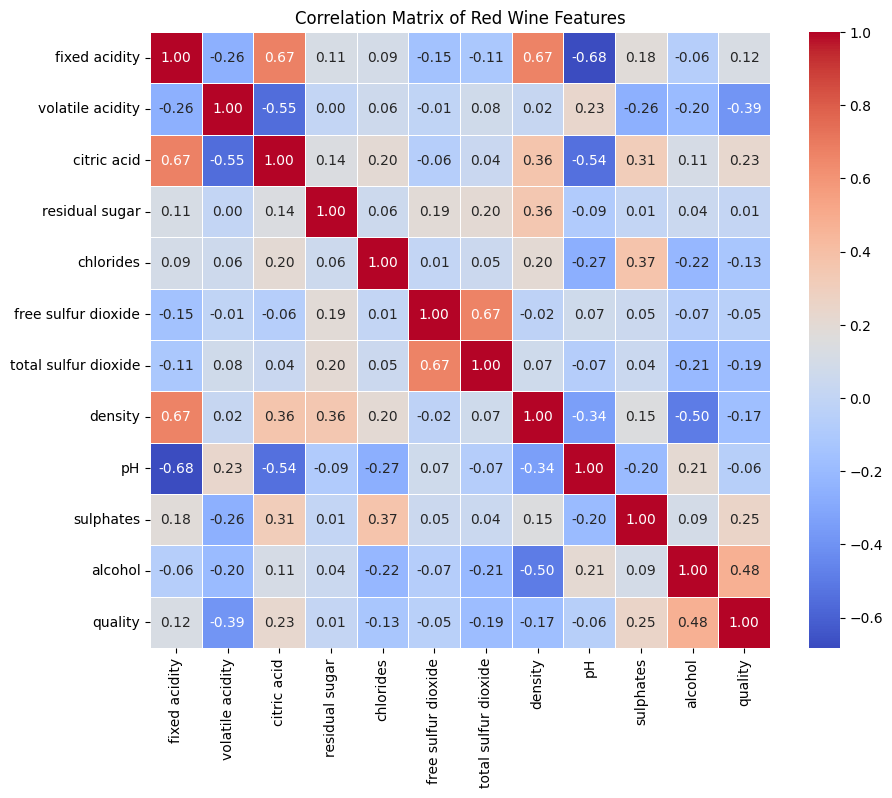

In [108]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Print the correlation coefficients
print("--- Top 5 Feature Correlations with Quality Score ---")
print(correlation_matrix['quality'].sort_values(ascending=False).head(5))

# Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=.5)
plt.title('Correlation Matrix of Red Wine Features')
plt.show()

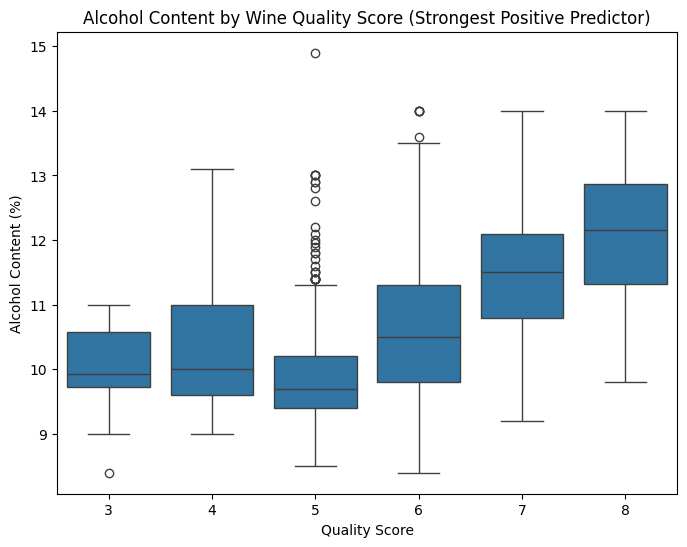

In [109]:
# Box plot: Alcohol Content vs. Quality Score (Key Feature)
plt.figure(figsize=(8, 6))
sns.boxplot(x='quality', y='alcohol', data=df)
plt.title('Alcohol Content by Wine Quality Score (Strongest Positive Predictor)')
plt.xlabel('Quality Score')
plt.ylabel('Alcohol Content (%)')
plt.show()

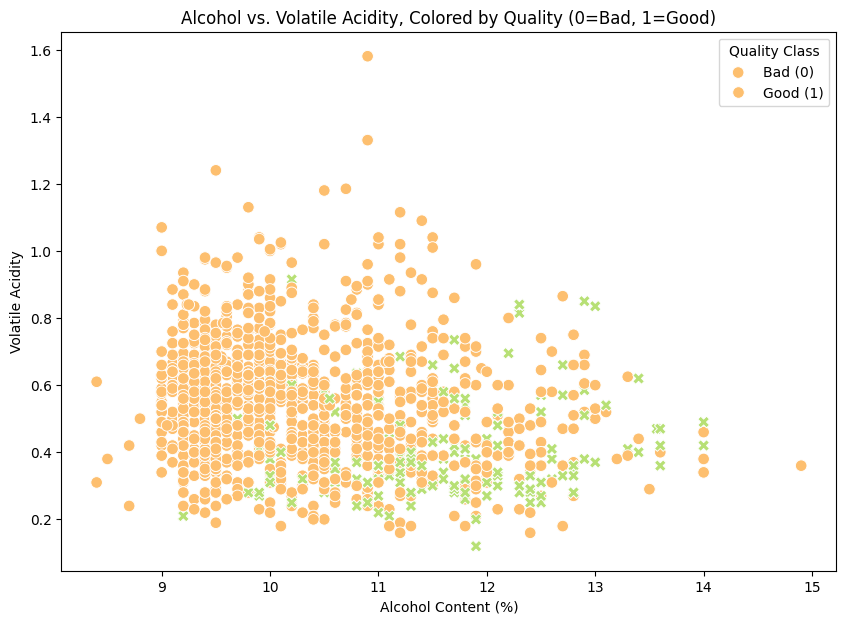

In [110]:
# Scatter Plot (Alcohol vs. Volatile Acidity, Colored by Quality Class)
df['quality_class'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='alcohol',
    y='volatile acidity',
    hue='quality_class',
    data=df,
    palette='RdYlGn', # Red/Yellow/Green color map
    style='quality_class',
    s=70
)
plt.title('Alcohol vs. Volatile Acidity, Colored by Quality (0=Bad, 1=Good)')
plt.xlabel('Alcohol Content (%)')
plt.ylabel('Volatile Acidity')
plt.legend(title='Quality Class', labels=['Bad (0)', 'Good (1)'])
plt.show()

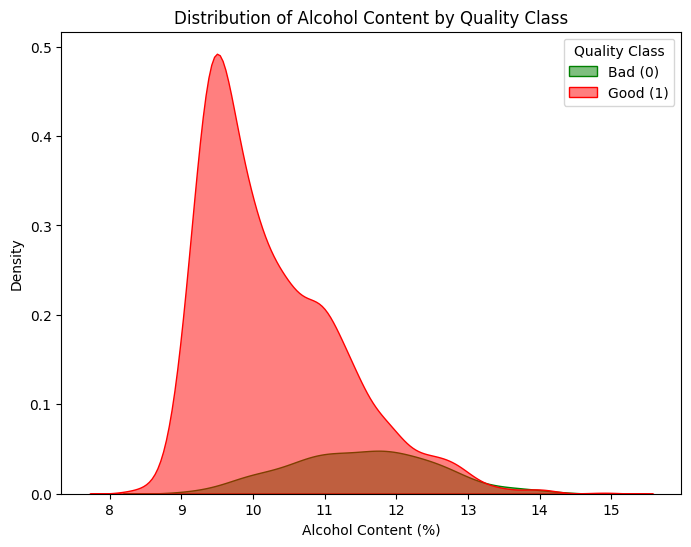

In [111]:
# KDE Plot of Alcohol Content, Separated by Quality

plt.figure(figsize=(8, 6))
# KDE plot smoothed distribution separated by the binary class
sns.kdeplot(
    data=df,
    x='alcohol',
    hue='quality_class',
    fill=True,
    alpha=0.5,
    palette=['red', 'green']
)
plt.title('Distribution of Alcohol Content by Quality Class')
plt.xlabel('Alcohol Content (%)')
plt.legend(title='Quality Class', labels=['Bad (0)', 'Good (1)'])
plt.show()

## Regression Model

In [112]:
# Define Features (X) and Regression Target (y)
X_reg = df.drop('quality', axis=1)
y_reg = df['quality']

# 80/20 Train-Test Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, stratify=y_reg
)

# Feature Scaling (Standardization)
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

In [113]:
# Initialize and Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg_scaled, y_train_reg)

# Make predictions and calculate RMSE
y_pred_reg = rf_regressor.predict(X_test_reg_scaled)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)

print("--- Random Forest Regression Results ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

--- Random Forest Regression Results ---
Root Mean Squared Error (RMSE): 0.4646


## Classification Model using GridSearchCV

In [114]:
# Convert Multi-class (3-8) to Binary (0=Bad, 1=Good)
df['quality_class'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Define Features (X) and Classification Target (y)
X_class = df.drop(['quality', 'quality_class'], axis=1)
y_class = df['quality_class']

# Re-split and Re-scale for Classification Target
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

In [115]:
# Instantiate the model with default hyperparameters
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train_class_scaled, y_train_class)


RandomForestClassifier(random_state=42)

In [116]:
# Make predictions and calculate accuracy
y_pred_class = rf_classifier.predict(X_test_class_scaled)
accuracy = accuracy_score(y_test_class, y_pred_class)

print("\n--- Baseline Random Forest Classification Results ---")
print(f"Overall Accuracy: {accuracy:.4f}")

# Classification Report: Shows detailed metrics for each class (0=Bad, 1=Good)
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=['Bad Wine (0)', 'Good Wine (1)']))


--- Baseline Random Forest Classification Results ---
Overall Accuracy: 0.9375

Classification Report:
               precision    recall  f1-score   support

 Bad Wine (0)       0.94      0.99      0.96       277
Good Wine (1)       0.93      0.58      0.71        43

     accuracy                           0.94       320
    macro avg       0.93      0.79      0.84       320
 weighted avg       0.94      0.94      0.93       320



In [117]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV setup:
#   estimator: the model to optimize
#   param_grid: the parameters to test
#   scoring: use weighted F1-Score (best for imbalanced classification)
#   cv=5: use 5-Fold Cross-Validation (standard practice)
#   verbose=3: prints status updates during the search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1
)

# Run the search on the training data
grid_search.fit(X_train_class_scaled, y_train_class)

# Extract the best model and parameters
best_rf_classifier = grid_search.best_estimator_
best_score = grid_search.best_score_

# Run the search on the training data
grid_search.fit(X_train_class_scaled, y_train_class)

# Extract the best model and parameters
best_rf_classifier = grid_search.best_estimator_
best_score = grid_search.best_score_

print("--- Optimized Parameters ---")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation F1 Weighted Score: {best_score:.4f}")

--- Optimized Parameters ---
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Best Cross-Validation F1 Weighted Score: 0.8872


## Final Model Evaluation

--- Optimized Random Forest Classification Final Results ---

FINAL CLASSIFICATION REPORT:
               precision    recall  f1-score   support

 Bad Wine (0)       0.94      0.99      0.96       277
Good Wine (1)       0.90      0.60      0.72        43

     accuracy                           0.94       320
    macro avg       0.92      0.80      0.84       320
 weighted avg       0.94      0.94      0.93       320



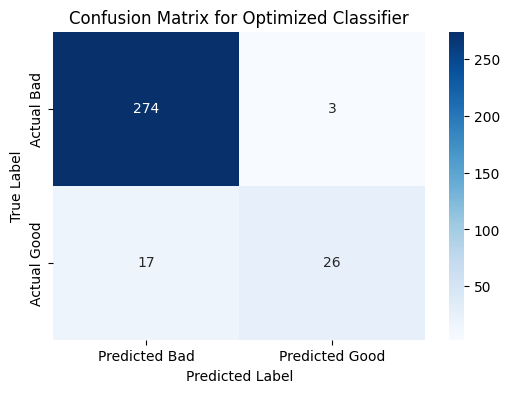

In [118]:
# Predict using the optimized model on the unseen test set
y_pred_final = best_rf_classifier.predict(X_test_class_scaled)

print("--- Optimized Random Forest Classification Final Results ---")

# Print the detailed Classification Report (key metrics: Precision, Recall, F1)
print("\nFINAL CLASSIFICATION REPORT:")
print(classification_report(y_test_class, y_pred_final, target_names=['Bad Wine (0)', 'Good Wine (1)']))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.title('Confusion Matrix for Optimized Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

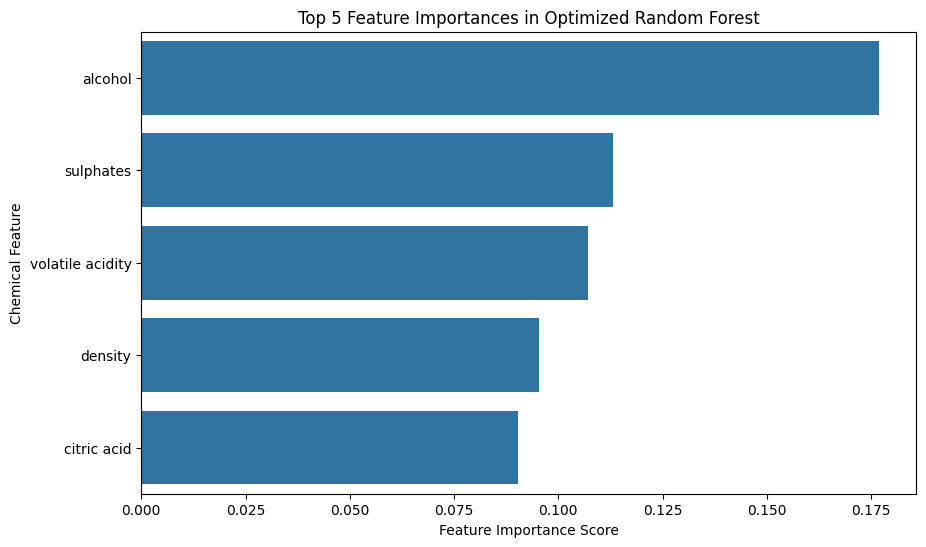

In [119]:
# Extract and sort feature importances
feature_names = X_class.columns
importances = best_rf_classifier.feature_importances_
feature_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the top 5 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_series.head(5), y=feature_series.index[:5])
plt.title('Top 5 Feature Importances in Optimized Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Chemical Feature')
plt.show()

## Model Persistence and Deployment Files

In [120]:
# Save the optimized model and the scaler for deployment
model_filename = 'final_rf_classifier.joblib'
scaler_filename = 'feature_scaler.joblib'

joblib.dump(best_rf_classifier, model_filename)

joblib.dump(scaler_class, scaler_filename)

print(f"Project assets saved: {model_filename} and {scaler_filename}")

Project assets saved: final_rf_classifier.joblib and feature_scaler.joblib
